In [278]:
import matplotlib.pyplot as plot
import geopandas as gpd
import earthpy as et
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [279]:
data = pd.read_csv("1976-2018-house2.csv", encoding="latin1")

In [280]:
# First 5 rows
data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
0,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Bill Davenport,democrat,False,total,58906,157170,False,20200424
1,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Jack Edwards,republican,False,total,98257,157170,False,20200424
2,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,NaN,NaN,True,total,7,157170,False,20200424
3,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,J. Carole Keahey,democrat,False,total,66288,156362,False,20200424
4,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,NaN,NaN,True,total,5,156362,False,20200424


# Vote Counts: Columns

year: year in which election was held

state: state name

description: state abbreviation

state_fips: numeric state code

state_cen: US census state code

state_ic: ICPSR state code

office: U.S. House (constant)

district: District number. At-large districts are coded as 0

stage: electoral stage ("gen" = general, "pri" = primary)

special: special election boolean (True = special election, False = regular election

candidate: name of candidate

party: party of candidate 

writein: boolean write in candidate (true = write-in, false = not write-in)

mode: mode of voting

candidatevotes: # of votes received by this candidate for this party

totalvates: total number of votes cast for this election

unofficial: boolean True/False (true = unofficial result)

version: date when this dataset was finalized

In [281]:
# Plot some distributions for 2018
data2018 = data[data["year"] == 2018]

In [282]:
data2018Candidate = data2018[["party", "state", "candidatevotes"]]
data2018Candidate

,party,state,candidatevotes
28251,democrat,Alabama,89226
28252,republican,Alabama,153228
28253,NaN,Alabama,163
28254,republican,Alabama,138879
28255,democrat,Alabama,86931
...,...,...,...
29631,NaN,Maryland,272
29632,democrat,Maryland,217679
29633,libertarian,Maryland,4853
29634,republican,Maryland,96525


In [283]:
# Get two dataframes
# One for democrat votes, one for republican votes.
# Group them by state.
demOnly = np.array(data2018Candidate["party"] == "democrat")
repOnly = np.array(data2018Candidate["party"] == "republican")
demVotes = data2018Candidate[demOnly].groupby(["state"]).sum()
repVotes = data2018Candidate[repOnly].groupby(["state"]).sum()

In [284]:
# Rename columns to get ready to join our dataframes.
demVotes = demVotes.rename(columns={"candidatevotes": "demVotes"})
repVotes = repVotes.rename(columns={"candidatevotes": "repVotes"})

Minnesota and North Dakota Have Null Democrat Votes, so we exclude them from this analysis.

In [285]:
# Join, then select rows with NaNs 
# To see which states are missing votes from
# either party
votesDiff = demVotes.join(repVotes, how="outer")
votesDiff[votesDiff.isnull().any(axis=1)]

,demVotes,repVotes
state,,
Minnesota,NaN,1125533
North Dakota,NaN,193568


In [286]:
# Join on all states that have votes on both parties.
votesState = demVotes.join(repVotes, how="inner")
votesState

,demVotes,repVotes
state,,
Alabama,678687,975737
Alaska,131199,149779
Arizona,1179193,1139251
Arkansas,312978,556339
California,8010445,3973396
Colorado,1343211,1079772
Connecticut,808652,512495
Delaware,227353,125384
Florida,3307232,3675417


# Raw vote counts by party

<AxesSubplot:ylabel='state'>

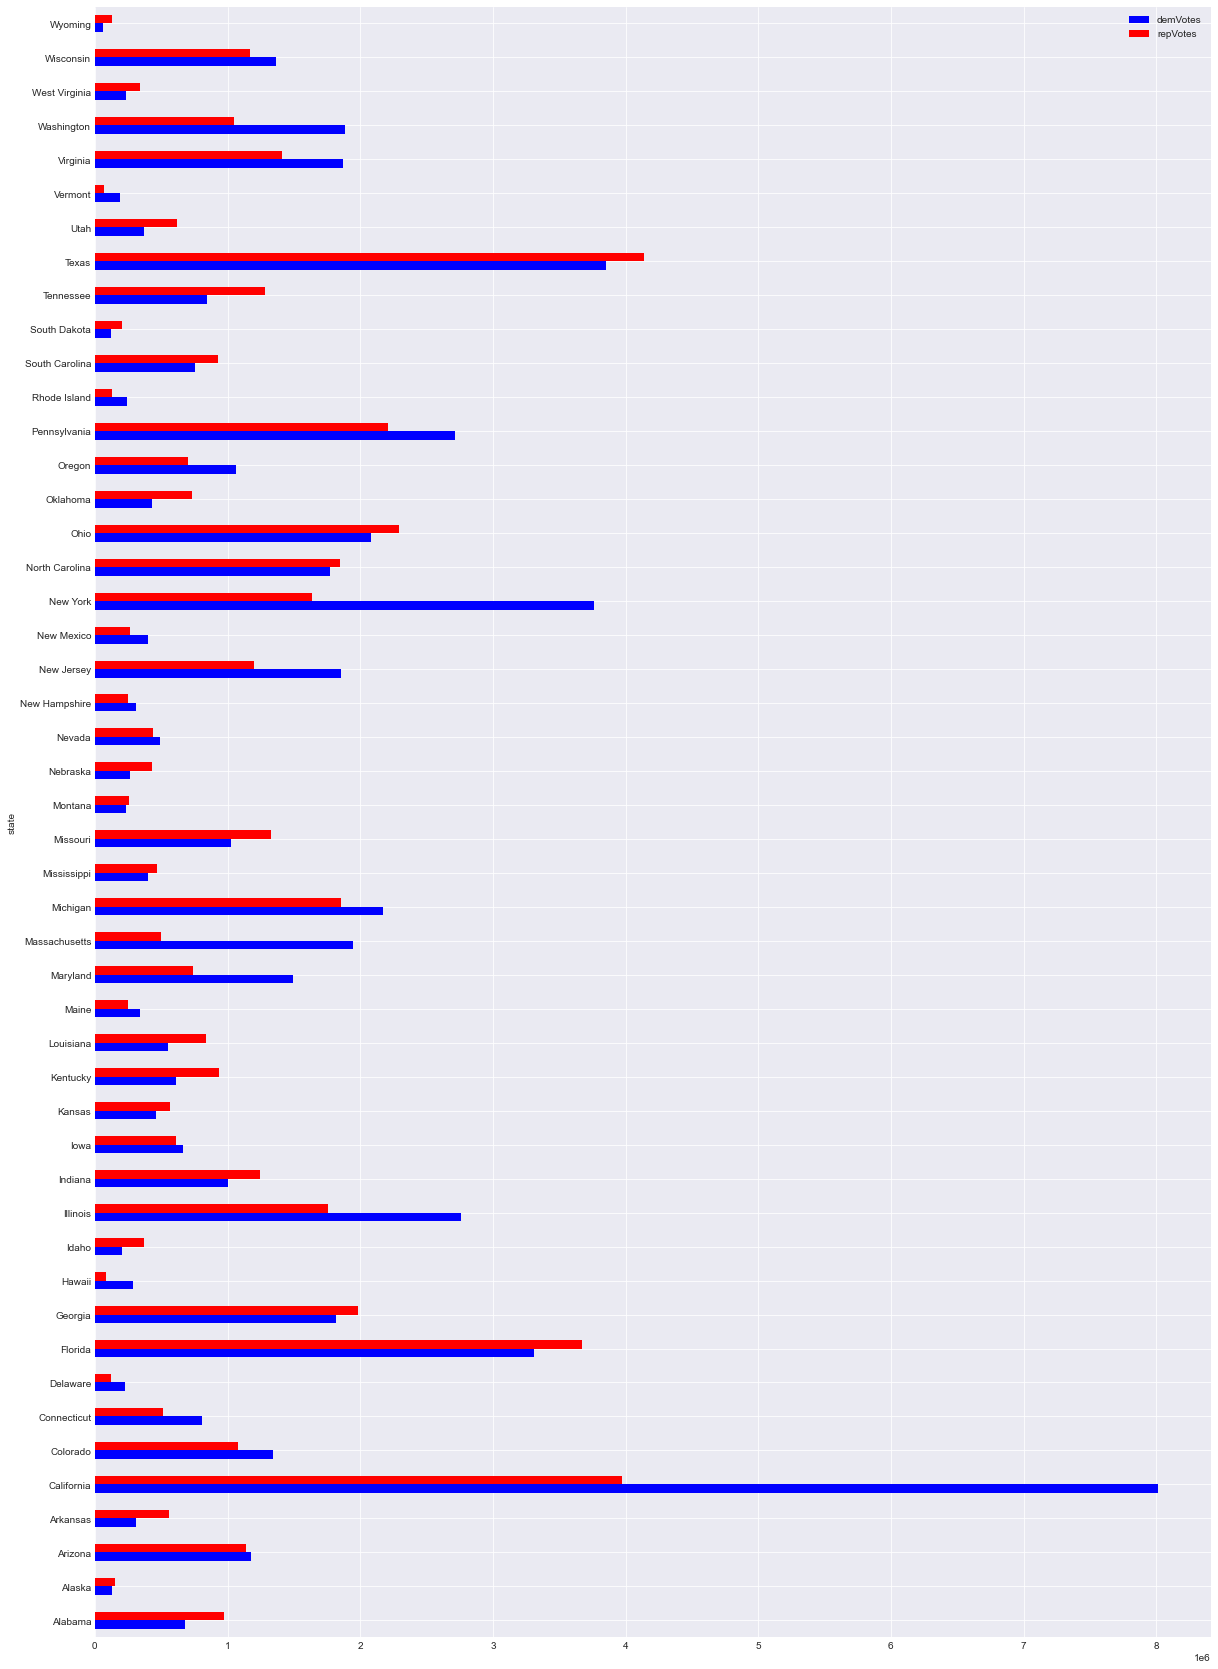

In [287]:
# Now plot a stacked bar chart.
votesState.plot.barh(figsize=(20, 30), color=["blue", "red"])

# Grouping vote counts by district

In [288]:
# Group by district and list total democrat and republican votes.
def groupDistricts(df, party):
    party_votes = data2018.loc[data["party"] == party]
    party_votes = party_votes.loc[:, ["state", "district", "candidatevotes"]]
    party_votes = party_votes.groupby(by=["state", "district"]).sum()
    return party_votes

dem_votes = groupDistricts(data2018, "democrat")
rep_votes = groupDistricts(data2018, "republican")
dem_votes = dem_votes.rename(columns={"candidatevotes": "dem_votes"})
rep_votes = rep_votes.rename(columns={"candidatevotes": "rep_votes"})
vote_counts = dem_votes.join(rep_votes, how="outer")
vote_counts.head()

dem_votes  rep_votes
state   district                      
Alabama 1           89226.0   153228.0
        2           86931.0   138879.0
        3           83996.0   147770.0
        4           46492.0   184255.0
        5          101388.0   159063.0

In [289]:
# Count only states with more than 3 districts.
def over_3_districts(state):
    if len(vote_counts.loc[state,:]) > 3:
        state_set.add(state)
state_set = set()  
[over_3_districts(state) for state, districts in vote_counts.index]

vote_counts = vote_counts.loc[state_set,:]

In [290]:
# As an example, look at the districts of louisiana.
vote_counts.loc["Louisiana", :]

,dem_votes,rep_votes
district,,
1,71521.0,192555.0
2,190182.0,NaN
3,74713.0,168263.0
4,72934.0,139326.0
5,67118.0,149018.0
6,76716.0,186553.0


In [291]:
# Come up with the winners for each district.
vote_counts["winner"] = vote_counts["dem_votes"] >= vote_counts["rep_votes"]
vote_counts["winner"] = vote_counts["winner"].apply(lambda win_bool: "d" if win_bool else "r")

In [292]:
# Calculate the wasted votes for each district.
def wasted_winner(total_votes_winner, district_vote_total):
    # Votes needed to win: 1 + (total votes / 2) 
    votes_needed = (district_vote_total / 2) + 1
    return total_votes_winner - (votes_needed)

dem_votes = vote_counts["dem_votes"]
rep_votes = vote_counts["rep_votes"]
rep_winner = np.array(vote_counts["winner"]) == "r"
total_votes = dem_votes + rep_votes

wasted_votes_dem = np.zeros(len(rep_winner))
wasted_votes_rep = np.zeros(len(rep_winner))

for i in range(len(rep_winner)):
    if rep_winner[i]:
        wasted_votes_rep[i] = wasted_winner(rep_votes[i], total_votes[i])
        wasted_votes_dem[i] = dem_votes[i]
    else:
        wasted_votes_dem[i] = wasted_winner(dem_votes[i], total_votes[i])
        wasted_votes_rep[i] = rep_votes[i]
        
vote_counts["wasted_republican"] = wasted_votes_rep
vote_counts["wasted_democrat"] = wasted_votes_dem


In [293]:
# Some races had no democrat or republican candidate.
# These can be seen in NaN columns.
# Drop these.
vote_counts = vote_counts.dropna()

In [294]:
# Come up with the winners for the above dataframe.
vote_counts["winner"].value_counts()

d    182
r    178
Name: winner, dtype: int64

In [295]:
vote_counts_bystate = vote_counts.groupby(by="state").sum()
vote_counts_bystate.head()

,dem_votes,rep_votes,wasted_republican,wasted_democrat
state,,,,
Alabama,493677.0,975737.0,241024.0,493677.0
Arizona,1066149.0,1139251.0,536982.0,565710.0
Arkansas,312978.0,556339.0,121676.5,312978.0
California,6608298.0,3802611.0,3026533.5,2178877.0
Colorado,1343211.0,1079772.0,579737.5,631747.0


In [296]:
def get_efficiency_gap(dem_votes, rep_votes, wasted_dem, wasted_rep):
    return (wasted_dem - wasted_rep) / (dem_votes + rep_votes)

vote_counts_bystate["e_gap"] = get_efficiency_gap(vote_counts_bystate["dem_votes"], 
                                          vote_counts_bystate["rep_votes"],
                                          vote_counts_bystate["wasted_democrat"],
                                          vote_counts_bystate["wasted_republican"])

vote_counts_bystate.head()

,dem_votes,rep_votes,wasted_republican,wasted_democrat,e_gap
state,,,,,
Alabama,493677.0,975737.0,241024.0,493677.0,0.171941
Arizona,1066149.0,1139251.0,536982.0,565710.0,0.013026
Arkansas,312978.0,556339.0,121676.5,312978.0,0.220060
California,6608298.0,3802611.0,3026533.5,2178877.0,-0.081420
Colorado,1343211.0,1079772.0,579737.5,631747.0,0.021465


KDE For Efficiency Gap -- Estimates the underlying distribution.

Our efficiency gap calculation is performed by counting the wasted democrat and wasted republican votes.

A vote is considered wasted if:

a) The vote was for a losing candidate in a district.

b) The vote for a winning candidate was beyond the threshold needed for that candidate to win, i.e. beyond 1 + (TotalVotes / 2)


Our efficiency gap formula used to make our calculation is as follows:

(dem_wasted_votes - rep_wasted_votes) / total_votes

This means that a positive value indicates more Democrat wasted votes, which indicates a gerrymander in favor of the Republican party. Likewise, a negative value indicates more Republican wasted votes and a gerrymander in favor of the Democratic party.


<AxesSubplot:xlabel='e_gap', ylabel='Density'>

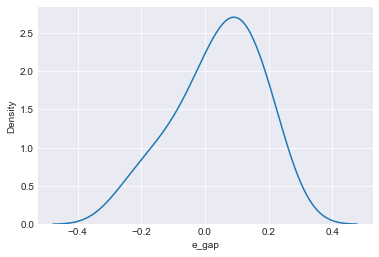

In [297]:
sns.kdeplot(vote_counts_bystate["e_gap"])

The efficiency gap distribution across the country has a slight negative skew, which indicates a slight Republican gerrymander across the US.



Next, plot efficiency gaps for every state.

The middle line is the mean, and the top and bottom lines are -2 and +2 stds from the mean respectively. This tells us which states our efficiency gap considers to be gerrymandered in a hypothesis test with a 68% confidence interval.

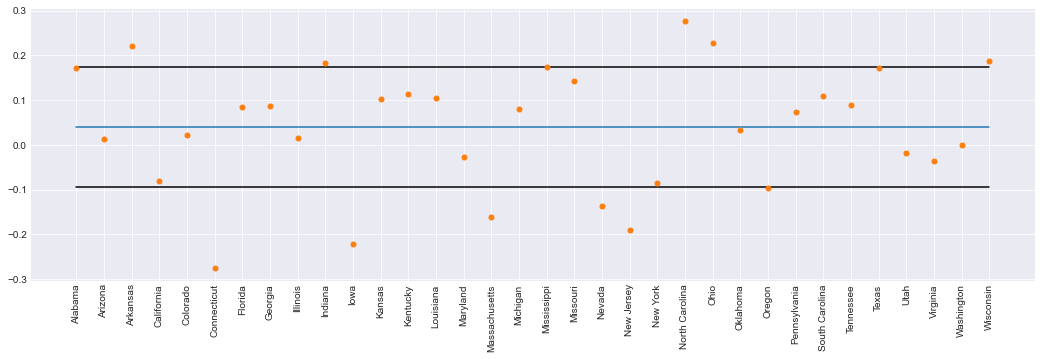

In [298]:
fig = plt.gcf()
fig.set_size_inches(18, 5)
plt.xticks(rotation=90)

average_e_gap = np.mean(vote_counts_bystate["e_gap"])
std_e_gap = np.std(vote_counts_bystate["e_gap"])
stateLength = len(vote_counts_bystate["e_gap"])


_ = plt.plot(np.arange(stateLength), [average_e_gap] * stateLength)
_ = plt.plot(np.arange(stateLength), [average_e_gap + 1 * std_e_gap] * stateLength, color="black")
_ = plt.plot(np.arange(stateLength), [average_e_gap - 1 * std_e_gap] * stateLength, color="black")
_ = plt.plot(vote_counts_bystate.reset_index()["state"], vote_counts_bystate["e_gap"], 
             linestyle="none",
            marker=".", markersize=10)

States with a republican bias (68% confidence from distribution):
Alabama, Indiana, North Carolina, Ohio, Wisconsin

States with a democrat bias (68% confidence from distribution):
Connecticut, Massachussetts, New Jersey, Oregon


skew=vote_counts_bystate.skew()
skew

In [299]:
# Normalizing efficiency gap numbers for future calculations
#from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()
#gap = np.array(vote_counts_bystate["e_gap"]).reshape(-1, 1)
#gap_normalized = min_max_scaler.fit_transform(gap)
#vote_counts_bystate["e_gap_normalized"] = gap_normalized

## Mean-Median Overview

The mean-median difference is a party’s median vote share minus its mean vote share, across all of a plan’s districts. For example, if a party has a median vote share of 45% and a mean vote share of 50%, then the plan has a mean-median difference of 5% against this party. When the mean and the median diverge significantly, the district distribution is skewed in favor of one party and against its opponent. Conversely, when the mean and the median are close, the district distribution is more symmetric.

Mean-Median difference essentially gives us a measure of skewness over a party's vote shares across its districts.

A large mean-median difference value for a party means that this party has a few districts that pull the mean away from the median. This is an indicator of packing, in which district lines pack voters of a party into a few districts to prevent them from winning races across the board in the state.

### Mean-Median Calculation

We derive two features from our vote count data to calculate the mean-median difference. These are labelled "dem_mm_diff" and "rep_mm_diff". This is done by first calculating the percent vote share for the two parties in their districts. For each state, we then average the vote shares for the two parties and get their medians. Finally, we difference the two (again, for each party) and this value is our mean-median difference value for the party.

A high dem_mm_diff value indicates that the democratic party is a victim of packing. Converesely, a high rep_mm_diff value indicates the same for the republican party.

In [300]:
vote_count_mm = vote_counts

In [301]:
dem_voteshare = vote_count_mm["dem_votes"] / (vote_count_mm["dem_votes"] + vote_count_mm["rep_votes"])
rep_voteshare = vote_count_mm["rep_votes"] / (vote_count_mm["dem_votes"] + vote_count_mm["rep_votes"])


total_dem_voteshare = dem_voteshare.groupby("state").sum()
total_districts = dem_voteshare.groupby("state").count()
dem_district_median = dem_voteshare.groupby("state").median()
dem_mean_share = total_dem_voteshare / total_districts

total_rep_voteshare = rep_voteshare.groupby("state").sum()
rep_district_median = rep_voteshare.groupby("state").median()
rep_mean_share = total_rep_voteshare / total_districts

vote_counts_bystate["dem_mm_diff"] = dem_mean_share - dem_district_median
vote_counts_bystate["rep_mm_diff"] = rep_mean_share - rep_district_median

In [302]:
vote_counts_bystate

,dem_votes,rep_votes,wasted_republican,wasted_democrat,e_gap,dem_mm_diff,rep_mm_diff
state,,,,,,,
Alabama,493677.0,975737.0,241024.0,493677.0,0.171941,-0.029543,0.029543
Arizona,1066149.0,1139251.0,536982.0,565710.0,0.013026,-0.000284,0.000284
Arkansas,312978.0,556339.0,121676.5,312978.0,0.220060,0.027093,-0.027093
California,6608298.0,3802611.0,3026533.5,2178877.0,-0.081420,-0.008178,0.008178
Colorado,1343211.0,1079772.0,579737.5,631747.0,0.021465,-0.007600,0.007600
Connecticut,808652.0,512495.0,512495.0,148073.5,-0.275837,-0.008802,0.008802
Florida,3104569.0,3675417.0,1406399.0,1983572.0,0.085129,0.018385,-0.018385
Georgia,1539063.0,1789039.0,688935.5,975103.5,0.085985,0.045823,-0.045823
Illinois,2757540.0,1754449.0,1090733.5,1165243.0,0.016514,-0.024519,0.024519


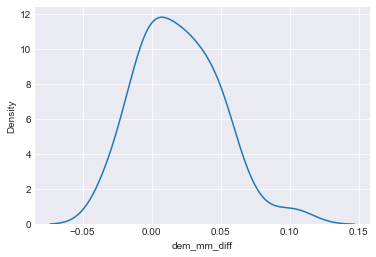

In [303]:
sns.kdeplot(vote_counts_bystate["dem_mm_diff"]);

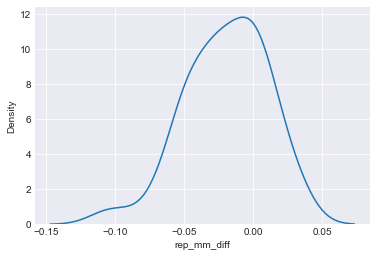

In [304]:
sns.kdeplot(vote_counts_bystate["rep_mm_diff"]);

C:\Users\dpale\anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()


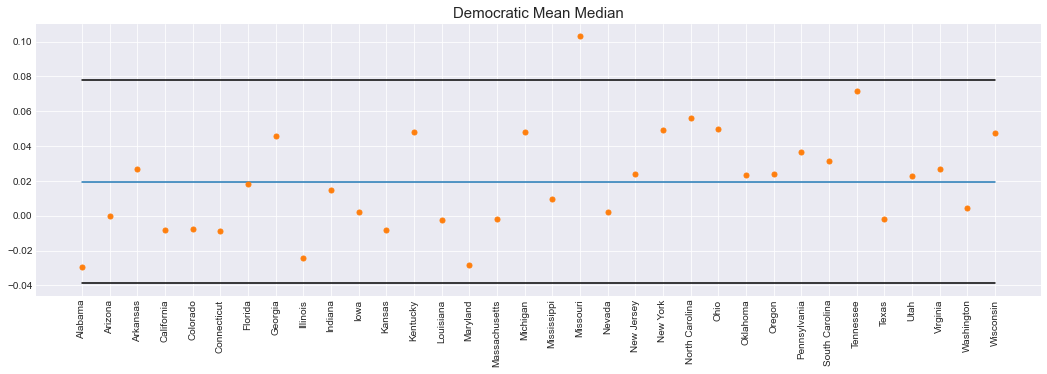

In [305]:
fig = plt.gcf()
fig.set_size_inches(18, 5)
plt.xticks(rotation=90)

average_dem_mean_median = np.mean(vote_counts_bystate["dem_mm_diff"])
std_dem_mean_median = np.std(vote_counts_bystate["dem_mm_diff"])
stateLength = len(vote_counts_bystate["dem_mm_diff"])


_ = plt.plot(np.arange(stateLength), [average_dem_mean_median] * stateLength)
_ = plt.plot(np.arange(stateLength), [average_dem_mean_median + 2 * std_dem_mean_median] * stateLength, color="black")
_ = plt.plot(np.arange(stateLength), [average_dem_mean_median - 2 * std_dem_mean_median] * stateLength, color="black")
_ = plt.plot(vote_counts_bystate.reset_index()["state"], vote_counts_bystate["dem_mm_diff"], 
             linestyle="none",
            marker=".", markersize=10)
plt.title("Democratic Mean Median",Fontsize = 15);

C:\Users\dpale\anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()


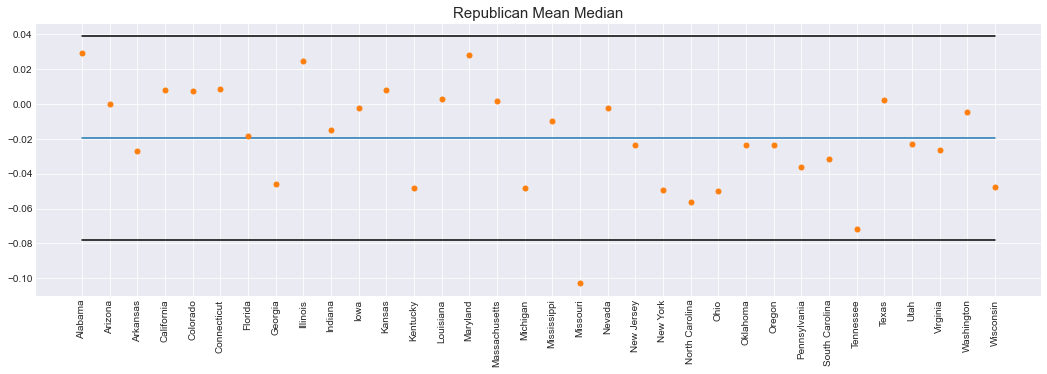

In [306]:
fig = plt.gcf()
fig.set_size_inches(18, 5)
plt.xticks(rotation=90)

average_rep_mean_median = np.mean(vote_counts_bystate["rep_mm_diff"])
std_rep_mean_median = np.std(vote_counts_bystate["rep_mm_diff"])
stateLength = len(vote_counts_bystate["rep_mm_diff"])


_ = plt.plot(np.arange(stateLength), [average_rep_mean_median] * stateLength)
_ = plt.plot(np.arange(stateLength), [average_rep_mean_median + 2 * std_rep_mean_median] * stateLength, color="black")
_ = plt.plot(np.arange(stateLength), [average_rep_mean_median - 2 * std_rep_mean_median] * stateLength, color="black")
_ = plt.plot(vote_counts_bystate.reset_index()["state"], vote_counts_bystate["rep_mm_diff"], 
             linestyle="none",
            marker=".", markersize=10)
plt.title("Republican Mean Median",Fontsize = 15);

# Partisan Bias

Partisan bias is another measure of gerrymandering. The partisan bias measurement uses the observed voting results and extrapolates them to create a hypothetical tied election. In this hypothetical tied election, we would expect both parties to receive 50% of congressional seats for their state. The partisan bias is the difference between the percentage of received seats by a party in this hypothetical election and 50%. A high value indicates that a party is receiving more seats than it "should" be given a tied election.

In [307]:
# First get the total vote difference.
# This number represents the number of votes above 50% a party received in a state.
def get_vote_diff(total_votes, total_votes_party, target_percent, districts):
    return ((total_votes_party / total_votes) - target_percent) * total_votes / districts

In [308]:
vote_counts_bystate.index

Index(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Indiana', 'Iowa',
       'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts',
       'Michigan', 'Mississippi', 'Missouri', 'Nevada', 'New Jersey',
       'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'South Carolina', 'Tennessee', 'Texas', 'Utah',
       'Virginia', 'Washington', 'Wisconsin'],
      dtype='object', name='state')

In [309]:
vote_counts.head(10)

dem_votes  rep_votes winner  wasted_republican  \
state       district                                                   
Nevada      1          100707.0    46978.0      d            46978.0   
            2          120102.0   167435.0      r            23665.5   
            3          148501.0   122566.0      d           122566.0   
            4          121962.0   102748.0      d           102748.0   
Connecticut 1          166155.0    96024.0      d            96024.0   
            2          167659.0   102483.0      d           102483.0   
            3          163211.0    95667.0      d            95667.0   
            4          168726.0   103175.0      d           103175.0   
            5          142901.0   115146.0      d           115146.0   
Virginia    1          148464.0   183250.0      r            17392.0   

                      wasted_democrat  
state       district                   
Nevada      1                 26863.5  
            2                120102.0  
            3                 12966.5  
            4                  9606.0  
Connecticut 1                 35064.5  
            2                 32587.0  
            3                 33771.0  
            4                 32774.5  
            5                 13876.5  
Virginia    1                148464.0

In [310]:
def get_pb():
    vote_counts_bystate_pb = vote_counts_bystate
    for state in (vote_counts_bystate.index):
        dem_votes = np.array(vote_counts.loc[state,"dem_votes"])
        rep_votes = np.array(vote_counts.loc[state,"rep_votes"])
        dem_votes_total = np.sum(dem_votes)
        rep_votes_total = np.sum(rep_votes)
        num_districts = len(vote_counts.loc[state,:])
        vote_total_state = np.sum([dem_votes, rep_votes])
        dem_votes_tied = dem_votes - (get_vote_diff(vote_total_state, dem_votes_total, .5, num_districts)) 
        rep_votes_tied = rep_votes - (get_vote_diff(vote_total_state,  rep_votes_total, .5, num_districts))
        rep_won_districts = np.sum(np.greater(rep_votes_tied, dem_votes_tied))
        dem_won_districts = np.sum(np.greater(dem_votes_tied, rep_votes_tied))
        rep_won_percent = rep_won_districts / num_districts
        dem_won_percent = dem_won_districts / num_districts
        vote_counts_bystate_pb.loc[state, "partisan_bias_rep"] = rep_won_percent - .5
        vote_counts_bystate_pb.loc[state, "partisan_bias_dem"] = dem_won_percent - .5
    return vote_counts_bystate_pb

vote_counts_bystate_partisan = get_pb()

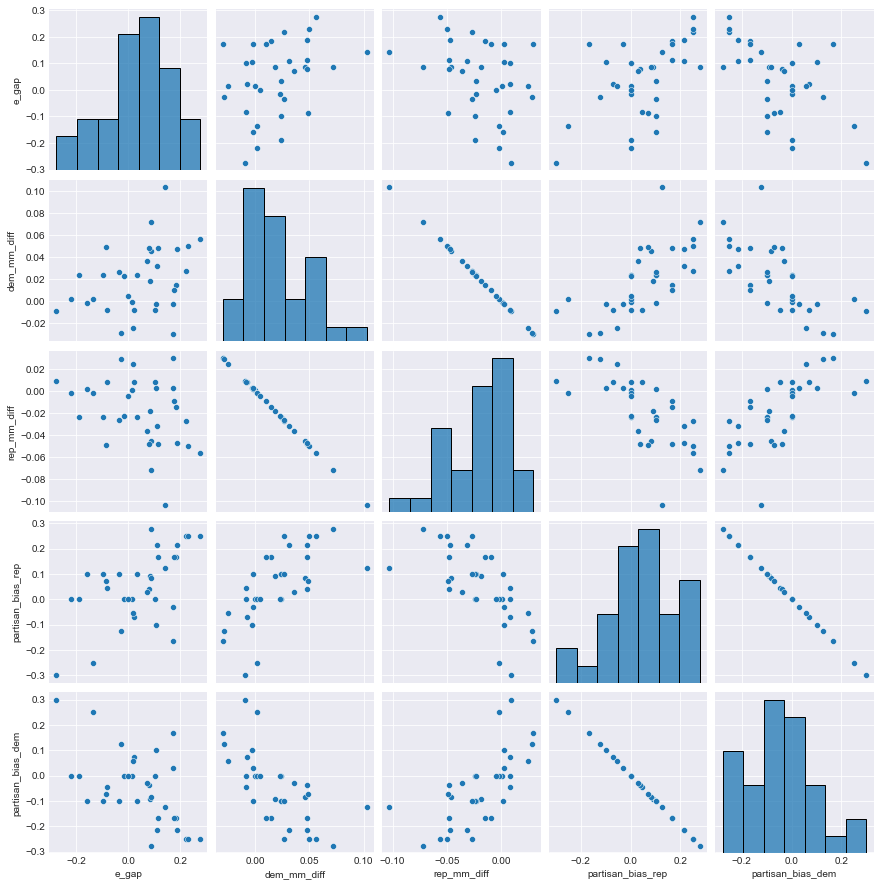

In [311]:
sns.pairplot(vote_counts_bystate.iloc[:,4:])

<AxesSubplot:>

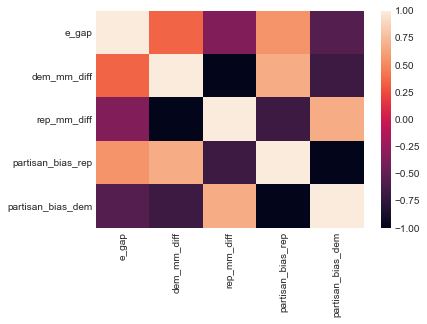

In [312]:
corr = vote_counts_bystate.iloc[:,4:].corr()
sns.heatmap(corr)

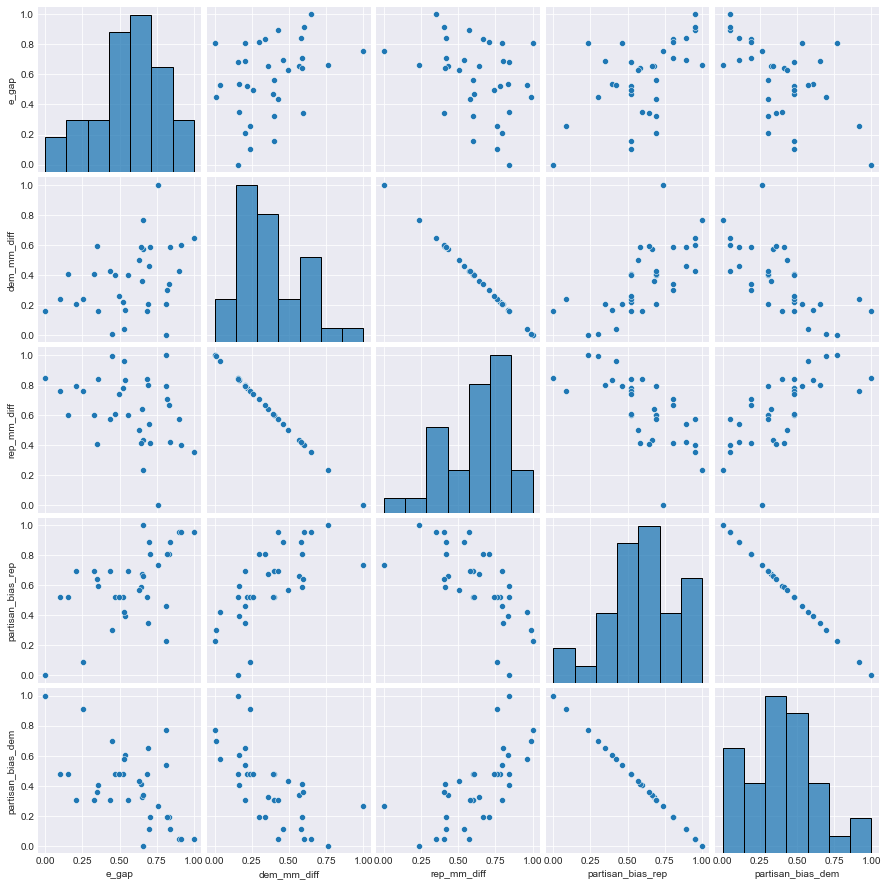

In [313]:
# Look for correlations between metrics
# by normalizing and pairplotting them
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
vote_counts_bystate_normalized = pd.DataFrame(min_max_scaler.fit_transform(vote_counts_bystate_partisan.iloc[:,4:]))
vote_counts_bystate_normalized.columns = vote_counts_bystate.iloc[:,4:].columns
sns.pairplot(vote_counts_bystate_normalized)


<AxesSubplot:>

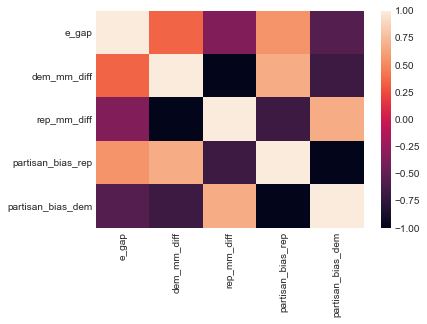

In [314]:
corr = vote_counts_bystate_normalized.corr()
sns.heatmap(corr)

In [315]:
vote_counts_bystate_normalized.head()

,e_gap,dem_mm_diff,rep_mm_diff,partisan_bias_rep,partisan_bias_dem
0,0.811374,0.000000,1.000000,0.230769,0.769231
1,0.523420,0.220803,0.779197,0.519231,0.480769
2,0.898564,0.427415,0.572585,0.951923,0.048077
3,0.352284,0.161228,0.838772,0.597902,0.402098
4,0.538711,0.165593,0.834407,0.395604,0.604396


## Partisan Bias By State

In [316]:
def avg_vote_per_state(state):
    ## gathering mean average of votes for the districts 
    i = vote_counts.loc[state]
    districtMean = (i['dem_votes'] + i['rep_votes']).mean()
    return districtMean


In [38]:
def partisan_bias(state):
    """
    Note: This is the definition used to caluculate partisan_bias 
    Computes the partisan bias for the given state.
    The partisan bias is defined as the number of districts with above-mean
    vote share by the first party divided by the total number of districts,
    minus 1/2.
    """
    
    distVoteAverage = avg_vote_per_state(state) ## Average votes for all districts in a state
    stateInfo = vote_counts.loc[state]
    demDist = np.array(stateInfo['dem_votes'])  ## number of votes for democratic party in a district 
    repDist = np.array(stateInfo['rep_votes'])  ## number of votes for republic party in a district
    
    above_avg_dists = 0
    num_dists = len(demDist)
    
    for i in range(num_dists):
        ## If the number of votes in a district is above the average number of votes
        if (demDist[i] + repDist[i]) > distVoteAverage:
            above_avg_dists = above_avg_dists+1   ## Number of districts that have votes above average 
    
    return (above_avg_dists / num_dists) - 0.5   ## returns the partisan_bias

In [39]:
state_names = vote_counts_bystate.index.values

partisanBias = [partisan_bias(state_names[i]) for i in range(len(state_names))]
vote_counts_bystate['partisan_bias']= partisanBias

vote_counts_bystate

,dem_votes,rep_votes,wasted_republican,wasted_democrat,e_gap,e_gap_normalized,dem_mean_median,rep_mean_median,partisan_bias_rep,partisan_bias
state,,,,,,,,,,
Alabama,493677.0,975737.0,241024.0,493677.0,0.171941,0.811374,4008.000000,-6477.333333,-0.166667,-0.166667
Arizona,1066149.0,1139251.0,536982.0,565710.0,0.013026,0.523420,4795.375000,8552.625000,0.000000,0.000000
Arkansas,312978.0,556339.0,121676.5,312978.0,0.220060,0.898564,-8776.500000,-1336.250000,0.250000,0.000000
California,6608298.0,3802611.0,3026533.5,2178877.0,-0.081420,0.352284,-2375.590909,-8905.977273,0.045455,0.000000
Colorado,1343211.0,1079772.0,579737.5,631747.0,0.021465,0.538711,-4248.285714,-5568.142857,-0.071429,-0.071429
Connecticut,808652.0,512495.0,512495.0,148073.5,-0.275837,0.000000,4424.600000,-16.000000,-0.300000,-0.100000
Florida,3104569.0,3675417.0,1406399.0,1983572.0,0.085129,0.654070,-7628.772727,14196.090909,0.090909,0.045455
Georgia,1539063.0,1789039.0,688935.5,975103.5,0.085985,0.655622,-12759.250000,3843.916667,0.083333,0.166667
Illinois,2757540.0,1754449.0,1090733.5,1165243.0,0.016514,0.529739,-2475.666667,-15228.388889,-0.055556,0.000000


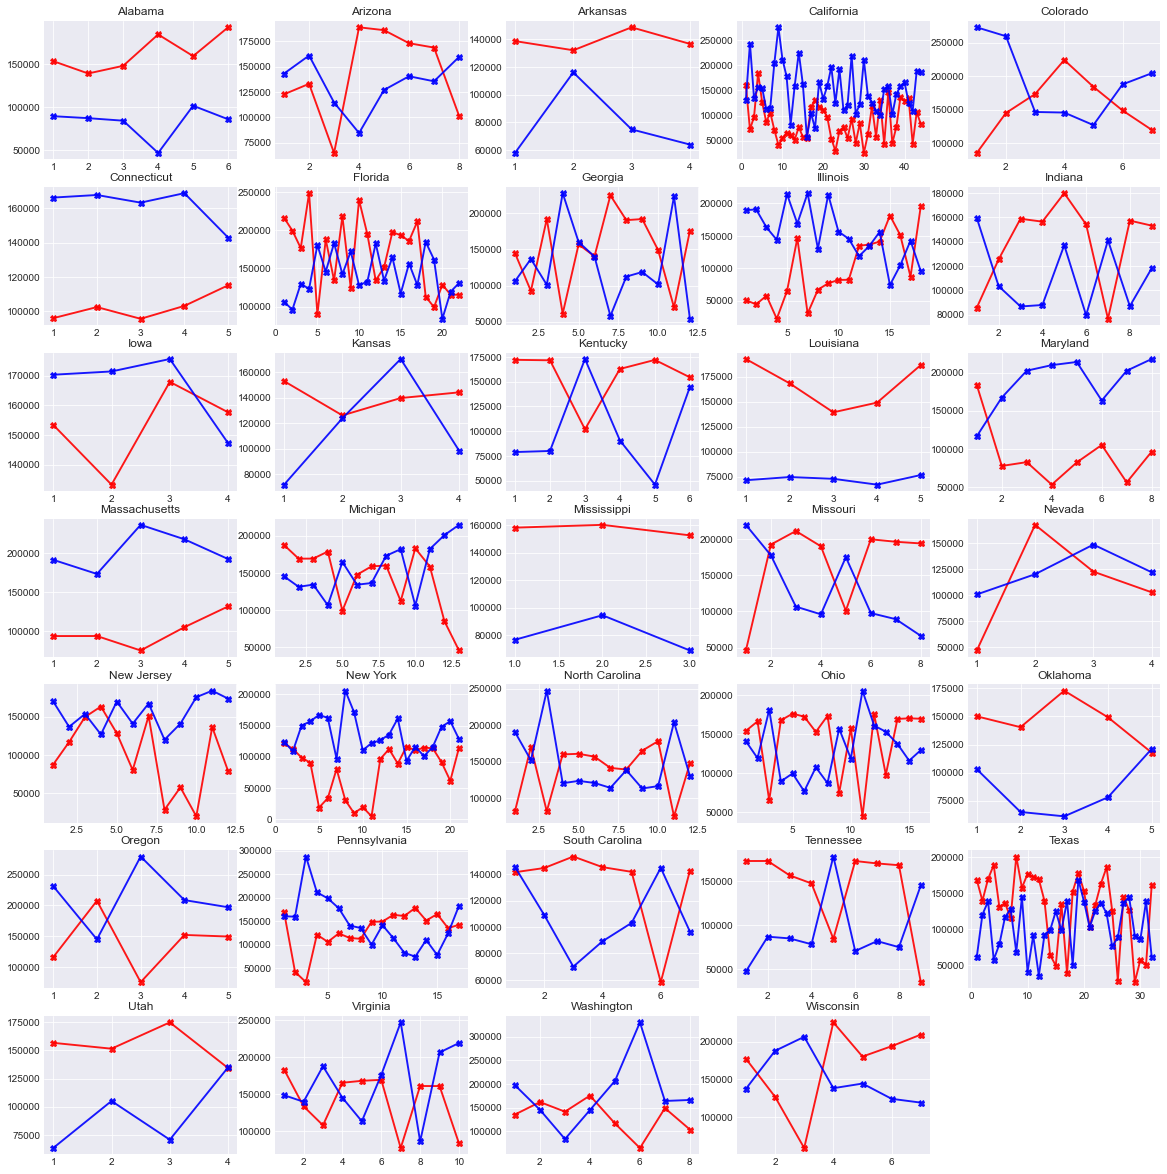

In [40]:
# Initialize the figure
plt.style.use('seaborn-darkgrid')

num=0
for column in state_names:
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(10,5, num)
    
    stateInfo = vote_counts.loc[column]
    demDist = np.array(stateInfo['dem_votes'])  ## number of votes for democratic party in a district 
    repDist = np.array(stateInfo['rep_votes'])  ## number of votes for republic party in a district
    
    numDist = range(1, len(repDist)+1)
    
    # Plot the lineplot
    plt.plot(numDist, repDist, marker='X', color="red", linewidth=1.9, alpha=0.9, label=column)
    plt.plot(numDist, demDist, marker='X', color="blue", linewidth=1.9, alpha=0.9, label=column)
    plt.title(column)
    
    plt.gcf().set_size_inches(20,30)

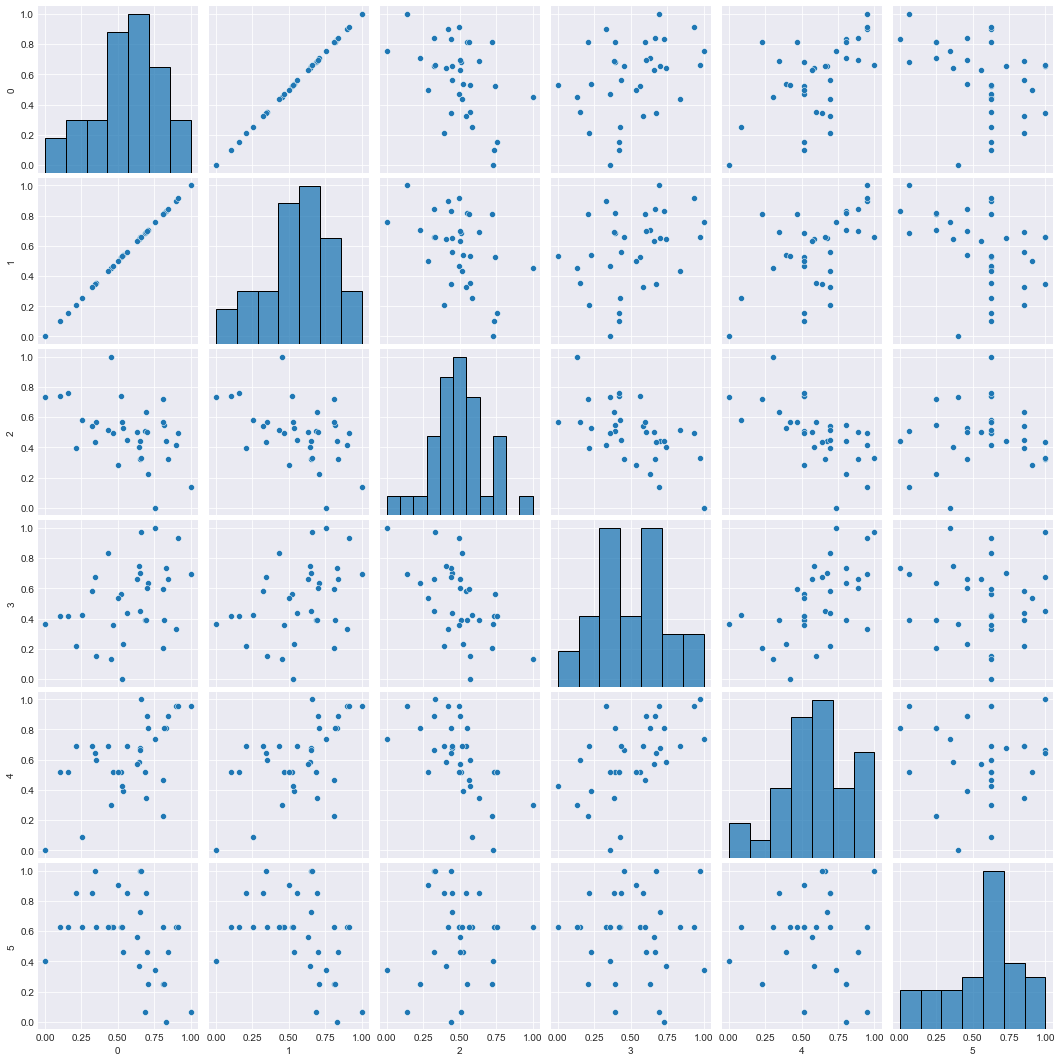

In [41]:
# Look for correlations between metrics
# by normalizing and pairplotting them
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
vote_counts_bystate_normalized = pd.DataFrame(min_max_scaler.fit_transform(vote_counts_bystate.iloc[:, 4:]))
vote_counts_bystate_normalized
sns.pairplot(vote_counts_bystate_normalized)

<AxesSubplot:>

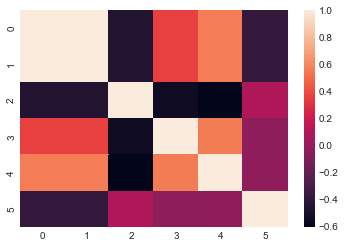

In [42]:
corr = vote_counts_bystate_normalized.corr()
sns.heatmap(corr)

In [43]:
# Run these cells to produce new CSV's for vote counts
vote_counts_bystate.to_csv("vote_counts_bystate.csv")
vote_counts.to_csv("vote_counts_bydistrict.csv")